## 线性回归

### 1. 假设我们有一些数据$x_1, \ldots, x_n \in \mathbb{R}$。我们的目标是找到一个常数$b$，使得最小化$\sum_i (x_i - b)^2$。
#### a. 找到最优值$b$的解析解。
#### b. 这个问题及其解与正态分布有什么关系?


### 2. 推导出使用平方误差的线性回归优化问题的解析解。为了简化问题，可以忽略偏置$b$（我们可以通过向$\mathbf X$添加所有值为1的一列来做到这一点）。
#### a. 用矩阵和向量表示法写出优化问题（将所有数据视为单个矩阵，将所有目标值视为单个向量）。

#### b. 计算损失对$w$的梯度。

#### c. 通过将梯度设为0、求解矩阵方程来找到解析解。

#### d. 什么时候可能比使用随机梯度下降更好？这种方法何时会失效？


### 3. 假定控制附加噪声$\epsilon$的噪声模型是指数分布。也就是说，$p(\epsilon) = \frac{1}{2} \exp(-|\epsilon|)$
#### a. 写出模型$-\log P(\mathbf y \mid \mathbf X)$下数据的负对数似然。


#### b. 请试着写出解析解。


#### c. 提出一种随机梯度下降算法来解决这个问题。哪里可能出错？（提示：当我们不断更新参数时，在驻点附近会发生什么情况）请尝试解决这个问题。

---
## 线性回归的从零开始实现


### 1. 如果我们将权重初始化为零，会发生什么。算法仍然有效吗？


features: tensor([-0.3403, -0.6979]) 
label: tensor([5.8988])


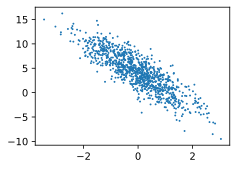

In [32]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l
# 构建人造数据集
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape) # 人工噪声
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000) 
print('features:', features[0], '\nlabel:', labels[0])
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(),
                labels.detach().numpy(), 1)

In [33]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))  # 生成一个从0到数据长度的序列，用作索引
    random.shuffle(indices)  # 打乱索引
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i + batch_size, num_examples)]) # 防止溢出
        yield features[batch_indices], labels[batch_indices]


batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

def linreg(X, w, b):
    return torch.matmul(X, w) + b

def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape))**2/2

def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

tensor([[ 0.9256,  0.1062],
        [-1.8683,  1.0197],
        [ 0.5794,  1.3423],
        [-1.0868,  0.2184],
        [ 0.3298,  0.9438],
        [-0.3142,  0.8763],
        [-1.9802, -0.8280],
        [-0.9342,  1.9215],
        [ 0.4530,  0.0326],
        [ 0.1830,  0.6647]]) 
 tensor([[ 5.6998],
        [-3.0081],
        [ 0.7948],
        [ 1.2915],
        [ 1.6478],
        [ 0.5733],
        [ 3.0623],
        [-4.2002],
        [ 4.9932],
        [ 2.3068]])


In [34]:
w = torch.zeros((2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')
        print(f'w:{w}, b:{b}')

epoch 1, loss 0.035059
w:tensor([[ 1.8814],
        [-3.2625]], requires_grad=True), b:tensor([4.0081], requires_grad=True)
epoch 2, loss 0.000129
w:tensor([[ 1.9932],
        [-3.3944]], requires_grad=True), b:tensor([4.1911], requires_grad=True)
epoch 3, loss 0.000050
w:tensor([[ 1.9992],
        [-3.3997]], requires_grad=True), b:tensor([4.1996], requires_grad=True)


loss明显增大了，但是结果是基本准确的

权重初始化为零可能导致：

1. **对称性问题**：在深度网络中，所有神经元的梯度相同，权重更新方向一致，网络无法学习有效特征。
2. **梯度消失**：如果输入数据对称且权重为零，梯度可能始终为零，导致权重无法更新。

**解释**：在这个线性回归模型中，由于数据随机性和模型简单性（无隐藏层），对称性问题不会出现，梯度也能正常计算，因此模型仍能收敛。但在深度网络中，建议使用随机初始化（如 Xavier 或 He 初始化）以避免这些问题。



### 2. 假设试图为电压和电流的关系建立一个模型。自动微分可以用来学习模型的参数吗?
$$U=IR$$
这是一个线性关系，模型可以学习到斜率R


### 3. 能基于[普朗克定律](https://en.wikipedia.org/wiki/Planck%27s_law)使用光谱能量密度来确定物体的温度吗？

#### 普朗克定律公式
1. **频率形式**：
    $$
   u(\nu, T) = \frac{8 \pi h \nu^3}{c^3} \cdot \frac{1}{e^{\frac{h \nu}{k_B T}} - 1}
   $$
   - $u(\nu, T)$：单位频率范围内的能量密度。
   - $\nu$：频率。
   - $h = 6.626 \times 10^{-34} \, \text{J} \cdot \text{s}$：普朗克常数。
   - $c = 3.0 \times 10^8 \, \text{m/s}$：光速。
   - $k_B = 1.381 \times 10^{-23} \, \text{J/K}$：玻尔兹曼常数。
   - $T$：黑体的绝对温度。

2. **波长形式**：
   $$
   u(\lambda, T) = \frac{8 \pi h c}{\lambda^5} \cdot \frac{1}{e^{\frac{h c}{\lambda k_B T}} - 1}
   $$
   - $u(\lambda, T)$：单位波长范围内的能量密度。
   - $\lambda$：波长。
  

可以，输入为长为2的向量（光谱能量密度和频率），输出为温度，不一定需要是线性关系。

#### **详细说明**

普朗克定律描述了黑体辐射的光谱能量密度 $u(\nu, T)$ 与频率 $\nu$ 和温度 $T$ 的关系：
$$
u(\nu, T) = \frac{8 \pi h \nu^3}{c^3} \cdot \frac{1}{e^{\frac{h \nu}{k_B T}} - 1}
$$

已知：
- 光谱能量密度 $u(\nu, T)$。
- 对应的频率 $\nu$。

目标：
- 求解温度 $T$。

从普朗克定律公式可以看到，$u(\nu, T)$ 是 $T$ 的非线性函数，但它是单调的（对于固定的 $\nu$）。因此，给定 $u(\nu, T)$ 和 $\nu$，可以通过数值方法反推出 $T$。

将普朗克定律公式改写为关于 $T$ 的方程：
$$
u(\nu, T) = \frac{8 \pi h \nu^3}{c^3} \cdot \frac{1}{e^{\frac{h \nu}{k_B T}} - 1}
$$

令：
$$
A = \frac{8 \pi h \nu^3}{c^3}
$$
则：
$$
u(\nu, T) = A \cdot \frac{1}{e^{\frac{h \nu}{k_B T}} - 1}
$$

进一步整理：
$$
e^{\frac{h \nu}{k_B T}} - 1 = \frac{A}{u(\nu, T)}
$$

$$
e^{\frac{h \nu}{k_B T}} = 1 + \frac{A}{u(\nu, T)}
$$

取对数：
$$
\frac{h \nu}{k_B T} = \ln\left(1 + \frac{A}{u(\nu, T)}\right)
$$

解出 $T$：
$$
T = \frac{h \nu}{k_B \cdot \ln\left(1 + \frac{A}{u(\nu, T)}\right)}
$$

可以使用神经网络求解
- **输入**：一个长度为 2 的向量：
  - 光谱能量密度 $u(\nu, T)$。
  - 对应的频率 $\nu$。
- **输出**：温度 $T$。

### 4. 计算二阶导数时可能会遇到什么问题？这些问题可以如何解决？
#### 存在什么问题？
1. 计算开销高：
二阶导数涉及对一阶导数再次求导，计算复杂度显著增加。
对于 $n$ 个参数，Hessian 矩阵的大小为 $n \times n$，计算和存储的开销都很大。
2. 内存消耗大：
在自动微分框架（如 PyTorch）中，计算二阶导数需要存储更多的中间结果，可能导致内存不足，尤其是在高维模型中。
3. 数值不稳定：
二阶导数的计算可能会引入数值误差，尤其是在梯度变化剧烈或模型复杂的情况下。
4. 不适用于大规模数据：
在大规模数据集上，计算二阶导数（如 Hessian 矩阵）可能不可行，因为需要对所有数据点进行二次计算。

#### 如何解决这些问题
1. **使用近似方法**：
   - 使用有限差分法近似二阶导数，而不是直接计算精确值。
   - 例如，Hessian 矩阵可以通过有限差分近似梯度的变化率。

2. **使用低秩近似**：
   - 对 Hessian 矩阵进行低秩近似，减少存储和计算开销。
   - 例如，使用共轭梯度法或 L-BFGS 方法。

3. **自动微分优化**：
   - 在框架中启用 `create_graph=True`，以支持高阶导数的计算，但需要注意内存管理。
   - 例如，在 PyTorch 中：

In [35]:
import torch
a = torch.tensor(2.0, requires_grad=True)
b = a**3
grad_1 = torch.autograd.grad(b, a, create_graph=True)[0]  # 一阶导数
grad_2 = torch.autograd.grad(grad_1, a)[0]  # 二阶导数
print(grad_2)

tensor(12.)



4. **使用更高效的优化方法**：
   - 在优化中，避免直接计算完整的二阶导数，而是使用一阶导数的优化方法（如随机梯度下降）。
   - 如果需要二阶信息，可以使用拟牛顿法（如 L-BFGS），它通过近似 Hessian 矩阵来减少计算量。

### 5. 为什么在`squared_loss`函数中需要使用`reshape`函数？


In [36]:
def squared_loss(y_hat, y):
    print(f"y_hat.shape：{y_hat.shape}, y.shape：{y.shape}")
    return (y_hat - y.reshape(y_hat.shape))**2/2

In [37]:
w = torch.zeros((2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')
        print(f'w:{w}, b:{b}')

y_hat.shape：torch.Size([10, 1]), y.shape：torch.Size([10, 1])
y_hat.shape：torch.Size([10, 1]), y.shape：torch.Size([10, 1])
y_hat.shape：torch.Size([10, 1]), y.shape：torch.Size([10, 1])
y_hat.shape：torch.Size([10, 1]), y.shape：torch.Size([10, 1])
y_hat.shape：torch.Size([10, 1]), y.shape：torch.Size([10, 1])
y_hat.shape：torch.Size([10, 1]), y.shape：torch.Size([10, 1])
y_hat.shape：torch.Size([10, 1]), y.shape：torch.Size([10, 1])
y_hat.shape：torch.Size([10, 1]), y.shape：torch.Size([10, 1])
y_hat.shape：torch.Size([10, 1]), y.shape：torch.Size([10, 1])
y_hat.shape：torch.Size([10, 1]), y.shape：torch.Size([10, 1])
y_hat.shape：torch.Size([10, 1]), y.shape：torch.Size([10, 1])
y_hat.shape：torch.Size([10, 1]), y.shape：torch.Size([10, 1])
y_hat.shape：torch.Size([10, 1]), y.shape：torch.Size([10, 1])
y_hat.shape：torch.Size([10, 1]), y.shape：torch.Size([10, 1])
y_hat.shape：torch.Size([10, 1]), y.shape：torch.Size([10, 1])
y_hat.shape：torch.Size([10, 1]), y.shape：torch.Size([10, 1])
y_hat.shape：torch.Size([

In [38]:
net(X, w, b), y

(tensor([[ 3.1562],
         [ 6.9458],
         [ 6.7207],
         [ 2.2293],
         [ 9.0724],
         [10.6135],
         [10.4407],
         [ 9.0143],
         [11.3665],
         [-1.8336]], grad_fn=<AddBackward0>),
 tensor([[ 3.1587],
         [ 6.9409],
         [ 6.7171],
         [ 2.2422],
         [ 9.0820],
         [10.6003],
         [10.4532],
         [ 9.0280],
         [11.3766],
         [-1.8393]]))

`y_hat` 和 `y` 都是列向量，需要一个是行向量，一个是列向量，才能进行矩阵乘法

### 6. 尝试使用不同的学习率，观察损失函数值下降的快慢。


In [39]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape))**2/2

In [40]:
w = torch.zeros((2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
lr = 10
num_epochs = 10
net = linreg
loss = squared_loss
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss nan


epoch 2, loss nan
epoch 3, loss nan
epoch 4, loss nan
epoch 5, loss nan
epoch 6, loss nan
epoch 7, loss nan
epoch 8, loss nan
epoch 9, loss nan
epoch 10, loss nan


In [41]:
w = torch.zeros((2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
lr = 5
num_epochs = 10
net = linreg
loss = squared_loss
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss nan
epoch 2, loss nan
epoch 3, loss nan
epoch 4, loss nan
epoch 5, loss nan
epoch 6, loss nan
epoch 7, loss nan
epoch 8, loss nan
epoch 9, loss nan
epoch 10, loss nan


In [42]:
w = torch.zeros((2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
lr = 1
num_epochs = 10
net = linreg
loss = squared_loss
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.000074
epoch 2, loss 0.000096
epoch 3, loss 0.000057
epoch 4, loss 0.000058
epoch 5, loss 0.000066
epoch 6, loss 0.000056
epoch 7, loss 0.000076
epoch 8, loss 0.000070
epoch 9, loss 0.000065
epoch 10, loss 0.000096


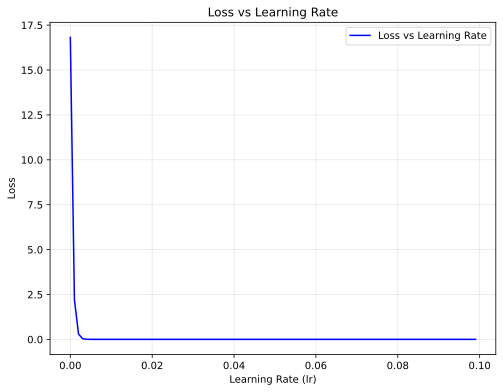

In [43]:
import matplotlib.pyplot as plt
import numpy as np

loss_list = []
lr_list = np.arange(0, 0.1, 0.001)  # 生成学习率列表

for lr in lr_list:
    w = torch.zeros((2, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    num_epochs = 10
    net = linreg
    loss = squared_loss
    for epoch in range(num_epochs):
        for X, y in data_iter(batch_size, features, labels):
            l = loss(net(X, w, b), y)
            l.sum().backward()
            sgd([w, b], lr, batch_size)
        with torch.no_grad():
            # 临时关闭梯度自动计算（即在算loss时不计算梯度，减少计算开销）
            train_l = loss(net(features, w, b), labels)
            # print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')
    
    avg_loss = float(train_l.mean())  # 转换为标量
    # print(f"train_l: {avg_loss}")
    loss_list.append(avg_loss)

plt.figure(figsize=(8, 6))
plt.plot(lr_list, loss_list, label="Loss vs Learning Rate", color="blue")
plt.xlabel("Learning Rate (lr)")
plt.ylabel("Loss")
plt.title("Loss vs Learning Rate")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
    

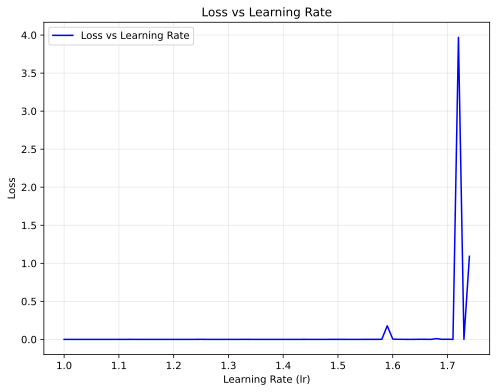

In [44]:
import matplotlib.pyplot as plt
import numpy as np

loss_list = []
lr_list = np.arange(1, 1.75, 0.01)  # 生成学习率列表

for lr in lr_list:
    w = torch.zeros((2, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    num_epochs = 10
    net = linreg
    loss = squared_loss
    for epoch in range(num_epochs):
        for X, y in data_iter(batch_size, features, labels):
            l = loss(net(X, w, b), y)
            l.sum().backward()
            sgd([w, b], lr, batch_size)
        with torch.no_grad():
            # 临时关闭梯度自动计算（即在算loss时不计算梯度，减少计算开销）
            train_l = loss(net(features, w, b), labels)
            # print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')
    
    avg_loss = float(train_l.mean())  # 转换为标量
    # print(f"train_l: {avg_loss}")
    loss_list.append(avg_loss)

plt.figure(figsize=(8, 6))
plt.plot(lr_list, loss_list, label="Loss vs Learning Rate", color="blue")
plt.xlabel("Learning Rate (lr)")
plt.ylabel("Loss")
plt.title("Loss vs Learning Rate")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
    

可以看到在lr在小于0.02和大于1.5时，效果变差，中间范围效果较好

### 7. 如果样本个数不能被批量大小整除，`data_iter`函数的行为会有什么变化？


In [45]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))  # 生成一个从0到数据长度的序列，用作索引
    random.shuffle(indices)  # 打乱索引
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i + batch_size, num_examples)]) # 防止溢出
        yield features[batch_indices], labels[batch_indices]


最后一轮会取剩余的所有数据

---
## 线性回归的简洁实现

### 1. 如果将小批量的平均损失替换为小批量的总损失，需要如何更改学习率？

1. **原始情况（平均损失）**  
   - 小批量损失：$ L_{\text{avg}} = \frac{1}{B} \sum_{i=1}^B L_i $  
   - 梯度：$ \nabla L_{\text{avg}} = \frac{1}{B} \sum_{i=1}^B \nabla L_i $  
   - 参数更新：$ \theta \leftarrow \theta - \eta \nabla L_{\text{avg}} $  

2. **改为总损失**  
   - 小批量损失：$ L_{\text{sum}} = \sum_{i=1}^B L_i = B \cdot L_{\text{avg}} $  
   - 梯度：$ \nabla L_{\text{sum}} = \sum_{i=1}^B \nabla L_i = B \cdot \nabla L_{\text{avg}} $  
   - 参数更新：$ \theta \leftarrow \theta - \eta \nabla L_{\text{sum}} = \theta - \eta B \nabla L_{\text{avg}} $  

3. **调整学习率**  
   - 总损失的梯度比平均损失大 $ B $ 倍，因此需要缩小学习率 $ B $ 倍以保持相同的更新步长：  
     $$
     \eta_{\text{new}} = \frac{\eta}{B}
     $$
   - 调整后的更新：  
     $$
     \theta \leftarrow \theta - \left( \frac{\eta}{B} \right) \cdot B \nabla L_{\text{avg}} = \theta - \eta \nabla L_{\text{avg}}
     $$
     与原始更新一致。  

In [220]:
import numpy as np
import torch
from torch import nn
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10 
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))

net = nn.Sequential(nn.Linear(2, 1)) 
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)
loss = nn.MSELoss(reduction='sum')
trainer = torch.optim.SGD(net.parameters(), lr=0.003)
num_epochs = 10
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.208657
epoch 2, loss 0.110084
epoch 3, loss 0.109942
epoch 4, loss 0.109885
epoch 5, loss 0.109863
epoch 6, loss 0.110223
epoch 7, loss 0.111417
epoch 8, loss 0.109727
epoch 9, loss 0.110219
epoch 10, loss 0.109806


### 2. 查看深度学习框架文档，它们提供了哪些损失函数和初始化方法？用Huber损失代替原损失，即
$$l(y,y') = \begin{cases}|y-y'| -\frac{\sigma}{2} & \text{ if } |y-y'| > \sigma \\ \frac{1}{2 \sigma} (y-y')^2 & \text{ 其它情况}\end{cases}$$


In [225]:
loss = nn.HuberLoss()
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000055
epoch 2, loss 0.000055
epoch 3, loss 0.000055
epoch 4, loss 0.000055
epoch 5, loss 0.000055
epoch 6, loss 0.000055
epoch 7, loss 0.000055
epoch 8, loss 0.000055
epoch 9, loss 0.000055
epoch 10, loss 0.000055


### 3. 如何访问线性回归的梯度？
假设`net`为一个层
通过 `net.weight.grad` 和 `net.bias.grad` 获取线性回归模型的梯度

In [228]:
loss = nn.HuberLoss()
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
        print(net[0].weight.grad)
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

tensor([[-0.0013, -0.0006]])
tensor([[0.0019, 0.0001]])
tensor([[ 0.0008, -0.0040]])
tensor([[-0.0035,  0.0006]])
tensor([[-0.0036,  0.0045]])
tensor([[-0.0012, -0.0021]])
tensor([[ 0.0010, -0.0028]])
tensor([[-0.0012, -0.0032]])
tensor([[0.0074, 0.0025]])
tensor([[4.3603e-05, 3.7005e-03]])
tensor([[6.5690e-04, 1.2548e-05]])
tensor([[-0.0004,  0.0011]])
tensor([[0.0028, 0.0053]])
tensor([[0.0072, 0.0029]])
tensor([[ 0.0010, -0.0017]])
tensor([[-0.0024,  0.0018]])
tensor([[3.9801e-05, 6.5715e-04]])
tensor([[-0.0041,  0.0026]])
tensor([[-0.0010, -0.0043]])
tensor([[ 0.0025, -0.0047]])
tensor([[0.0018, 0.0008]])
tensor([[0.0107, 0.0043]])
tensor([[-0.0004,  0.0006]])
tensor([[-0.0009, -0.0014]])
tensor([[0.0043, 0.0016]])
tensor([[-0.0025,  0.0010]])
tensor([[0.0003, 0.0017]])
tensor([[0.0029, 0.0036]])
tensor([[ 0.0017, -0.0010]])
tensor([[ 0.0035, -0.0014]])
tensor([[7.7762e-05, 1.3098e-04]])
tensor([[-0.0013,  0.0005]])
tensor([[-0.0075,  0.0039]])
tensor([[ 0.0007, -0.0006]])
tensor([

---
## softmax回归

### 1. 我们可以更深入地探讨指数族与softmax之间的联系。
#### a. 计算softmax交叉熵损失$l(\mathbf{y},\hat{\mathbf{y}})$的二阶导数。
#### b. 计算$\mathrm{softmax}(\mathbf{o})$给出的分布方差，并与上面计算的二阶导数匹配。

### 2. 假设我们有三个类发生的概率相等，即概率向量是$(\frac{1}{3}, \frac{1}{3}, \frac{1}{3})$。
#### a. 如果我们尝试为它设计二进制代码，有什么问题？
#### b. 请设计一个更好的代码。提示：如果我们尝试编码两个独立的观察结果会发生什么？如果我们联合编码$n$个观测值怎么办？

### 3. softmax是对上面介绍的映射的误称（虽然深度学习领域中很多人都使用这个名字）。真正的softmax被定义为$\mathrm{RealSoftMax}(a, b) = \log (\exp(a) + \exp(b))$。
#### a. 证明$\mathrm{RealSoftMax}(a, b) > \mathrm{max}(a, b)$。
#### b. 证明$\lambda^{-1} \mathrm{RealSoftMax}(\lambda a, \lambda b) > \mathrm{max}(a, b)$成立，前提是$\lambda > 0$。
#### c. 证明对于$\lambda \to \infty$，有$\lambda^{-1} \mathrm{RealSoftMax}(\lambda a, \lambda b) \to \mathrm{max}(a, b)$。
#### d. soft-min会是什么样子？
#### e. 将其扩展到两个以上的数字。

---
## 图像分类数据集

#### 1. 减少`batch_size`（如减少到1）是否会影响读取性能？


会极大的影响性能（读取速度）

array([<Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'dress'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'trouser'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'shirt'}>,
       <Axes: title={'center': 'coat'}>,
       <Axes: title={'center': 'dress'}>,
       <Axes: title={'center': 'trouser'}>,
       <Axes: title={'center': 'co

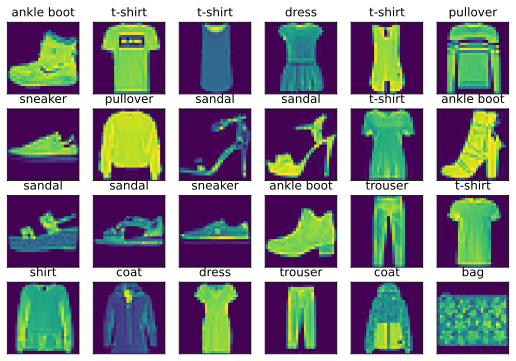

In [234]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import  transforms
from d2l import torch as d2l

d2l.use_svg_display()

trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../../data", train=True, transform=trans,download=True
)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../../data", train=False, transform=trans, download=True
)

len(mnist_train), len(mnist_test)

mnist_train[0][0].shape

def get_fashion_mnist_labels(labels):
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = [
        't-shirt', 'trouser', 'pullover', 
        'dress', 'coat', 'sandal', 'shirt',
        'sneaker', 'bag', 'ankle boot'
    ]
    return [text_labels[int(i)] for i in labels ] 

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """绘制图片"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

X, y = next(iter(data.DataLoader(mnist_train, batch_size=24)))
show_images(X.reshape(24, 28, 28), 4, 6, titles=get_fashion_mnist_labels(y))


In [ ]:
batch_size = 256

def get_dataloader_workers():
    """使用4个进程来读取的数据"""
    return 8

train_iter = data.DataLoader(
    mnist_train, batch_size, shuffle=True,
    num_workers=get_dataloader_workers()
)

timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'0.46 sec'

In [237]:
batch_size = 1

def get_dataloader_workers():
    """使用4个进程来读取的数据"""
    return 8

train_iter = data.DataLoader(
    mnist_train, batch_size, shuffle=True,
    num_workers=get_dataloader_workers()
)

timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'21.11 sec'

#### 2. 数据迭代器的性能非常重要。当前的实现足够快吗？探索各种选择来改进它。

完全没有思路......
贴一个AI的回答吧（后面会不会学到呢？）

**1. 存储优化**
- **使用 SSD**：将数据存储在固态硬盘上。
- **高效数据格式**：使用 TFRecord、HDF5 或 LMDB 格式存储数据。

**2. 数据加载优化**
- **多线程/多进程**：增加 `DataLoader` 的 `num_workers` 参数（如 `num_workers=4`）。
- **分布式加载**：在多 GPU 或多节点训练中，使用 `DistributedSampler`。
（这个我们已经在用了）

**3. 数据预处理优化**
- **并行数据增强**：在 `DataLoader` 中集成数据增强操作。
- **GPU 加速预处理**：使用 NVIDIA DALI 等工具将预处理移到 GPU。

**4. 数据加载与训练并行**
- **预取数据**：使用 `prefetch_generator` 或类似工具。
- **异步加载**：通过多线程或多进程异步加载数据。

**5. 缓存数据**
- **内存缓存**：将小数据集全部加载到内存中。
- **磁盘缓存**：预处理后将数据保存到磁盘，避免重复计算。

**6. 使用高性能工具**
- **NVIDIA DALI**：专为深度学习设计的高性能数据加载和预处理库。
- **PyTorch Lightning**：自动优化数据加载和训练流程。



#### 3. 查阅框架的在线API文档。还有哪些其他数据集可用？
https://docs.pytorch.org/vision/stable/datasets.html


---
## softmax回归的从零开始实现


### 1. 本节直接实现了基于数学定义softmax运算的`softmax`函数。这可能会导致什么问题？提示：尝试计算$\exp(50)$的大小。

In [1]:
import math
math.exp(50)

5.184705528587072e+21

x过大时，可能会溢出，可以使用：
$$ y_i = \frac{e^{x_i - c}}{\sum_{j=1}^n e^{x_j - c}} $$ 
通过一个常数C解决溢出问题。

### 2. 本节中的函数`cross_entropy`是根据交叉熵损失函数的定义实现的。它可能有什么问题？提示：考虑对数的定义域。

In [2]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

`y_hat`为模型预测输出，`y`为真实标签

`range(len(y_hat))` 和样本长度相同的数组，用作样本索引

`range(len(y_hat)), y`选择对应样本的正确标签

`y_hat[range(len(y_hat)), y]`读取正确标签的对应概率

对数定义域为$( 0, \infty )$， softmax输出可能为0吗？

In [3]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # 广播机制

根据`softmax`函数的定义，输出的概率不不可能为零，但可能是一个极小值，经过log运算后，会变得非常大，可能会导致梯度爆炸或者训练失败。

### 3. 请想一个解决方案来解决上述两个问题。
对于`softmax`函数的溢出问题，运算时减去一个C：

In [6]:
def softmax(X):
    C = torch.max(X)
    X_exp = torch.exp(X-C)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  

对于`cross_entropy`导致`loss`过大的问题，可以加上一个极小值避免$log(0)$：

In [7]:
def cross_entropy(y_hat, y):
    eps = 1e-12  # 避免 log(0)
    y_hat = torch.clamp(y_hat, min=eps)
    return -torch.log(y_hat[range(len(y_hat)), y])

### 4. 返回概率最大的分类标签总是最优解吗？例如，医疗诊断场景下可以这样做吗？
不可以，医疗场景下，对个病症可能同时出现，并且错误的风险是不能被接受的，应该至少考虑输出的前几个，或者所有可能的方向。

### 5. 假设我们使用softmax回归来预测下一个单词，可选取的单词数目过多可能会带来哪些问题?
单词数量过多，导致`softmax`中分子过小，每个单词之间概率的差值变小，置信度变低。


---
## softmax回归的简洁实现

### 1. 尝试调整超参数，例如批量大小、迭代周期数和学习率，并查看结果。


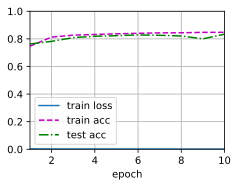

In [14]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
lr = 0.1
num_epochs = 10
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

loss = nn.CrossEntropyLoss()

trainer = torch.optim.SGD(net.parameters(), lr=0.1)

d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

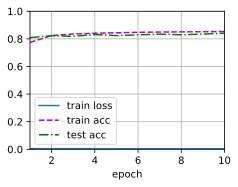

In [15]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 128
lr = 0.1
num_epochs = 10
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

loss = nn.CrossEntropyLoss()

trainer = torch.optim.SGD(net.parameters(), lr=0.1)

d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

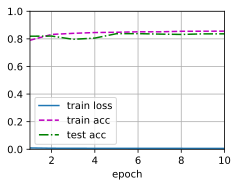

In [16]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 64
lr = 0.1
num_epochs = 10
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

loss = nn.CrossEntropyLoss()

trainer = torch.optim.SGD(net.parameters(), lr=0.1)

d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

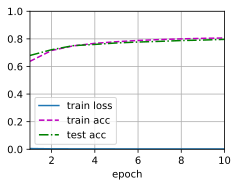

In [22]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
lr = 0.01
num_epochs = 10
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

loss = nn.CrossEntropyLoss()

trainer = torch.optim.SGD(net.parameters(), lr=lr)

d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

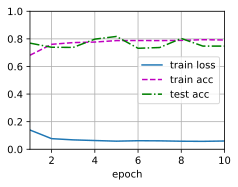

In [23]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
lr = 10
num_epochs = 10
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

loss = nn.CrossEntropyLoss()

trainer = torch.optim.SGD(net.parameters(), lr=lr)

d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

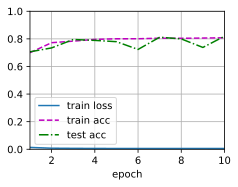

In [24]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
lr = 1
num_epochs = 10

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

loss = nn.CrossEntropyLoss()

trainer = torch.optim.SGD(net.parameters(), lr=lr)

d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

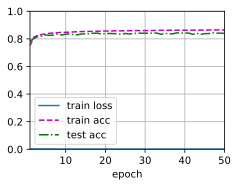

In [26]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
lr = 0.1
num_epochs = 50
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

loss = nn.CrossEntropyLoss()

trainer = torch.optim.SGD(net.parameters(), lr=lr)

d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

### 2. 增加迭代周期的数量。为什么测试精度会在一段时间后降低？我们怎么解决这个问题？
并没有发现测试精度下降的问题，是过拟合的问题吗？？？